Xinyuan Chen HW3 (main)

## Approach

Find a weight for Jaccard similarity (see [baseline.ipynb](./baseline.ipynb)) and recipe popularity percentile (see [baselines.ipy](./baselines.py)), and calculate the weighed average.

If the weighed average >= a value we set (here we use 0.5), the user_id and recipe_id combination is predicted to be actually have happened.

importing Jupyter notebook from baseline.ipynb


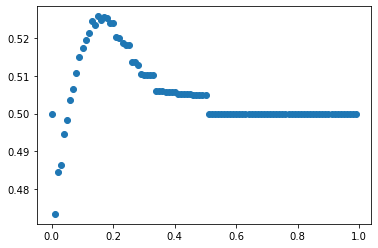

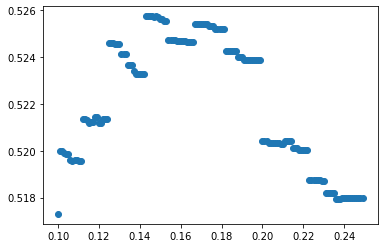

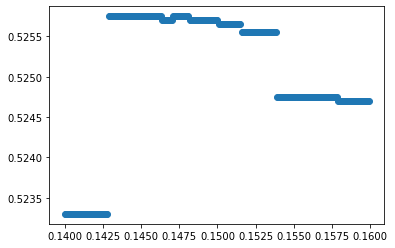

In [2]:
# make ipynb files importable
from jupyter_utils_tddschn import notebook_importer

# import the baseline.ipynb file
import baseline

In [3]:
from baseline import *

In [7]:
d.shape
X_train.shape
recipes_train = X_train[:, :-1]
recipes_train = recipes_train.copy()
recipes_train.resize((X_train.shape[0],))
recipes_train.shape

(490000,)

In [8]:
from collections import Counter, defaultdict
import numpy as np
recipe_counts = Counter(recipes_train)

In [9]:
recipe_counts.most_common(3)

[(32445558, 4671), (95482435, 3418), (54496210, 2847)]

In [10]:
most_common_recipes = recipe_counts.most_common()

In [16]:
most_common_recipes_id_normalized = [(i + 1, most_common_recipes[i][1]) for i in range(len(most_common_recipes))]

In [17]:
len(most_common_recipes_id_normalized)
most_common_recipes_id_normalized[:3], most_common_recipes_id_normalized[-3:]

([(1, 4671), (2, 3418), (3, 2847)], [(13514, 1), (13515, 1), (13516, 1)])

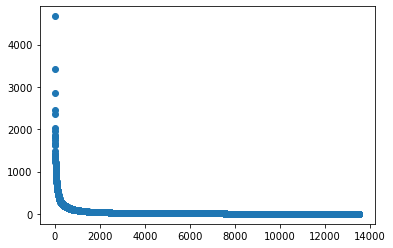

In [18]:
plt.scatter(*zip(*most_common_recipes_id_normalized, strict=True))
plt.show()

In [21]:
recipe_quantiles: dict[int, float] = {}
cum_count = 0
for recipe, count in most_common_recipes:
	recipe_quantiles[recipe] = cum_count / len(recipes_train)
	cum_count += count


In [22]:
import itertools
dict(itertools.islice(recipe_quantiles.items(), 5))

{32445558: 0.0,
 95482435: 0.00953265306122449,
 54496210: 0.016508163265306124,
 43615275: 0.022318367346938775,
 59129763: 0.027351020408163264}

In [23]:
recipe_quantiles_values = list(recipe_quantiles.values())
recipe_quantiles_id_normalized: list[int, float] = [(i + 1, recipe_quantiles_values[i]) for i in range(len(recipe_quantiles_values))]

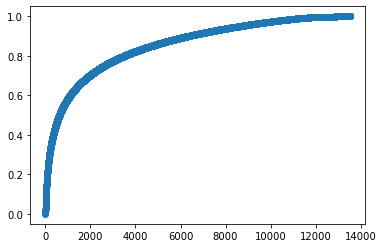

In [24]:
plt.scatter(*zip(*recipe_quantiles_id_normalized, strict=True))
plt.show()

In [33]:
from collections import defaultdict
jaccard_max_sims_dict: dict[tuple[int, int], float] = defaultdict(float)
for u, r in X_test_and_random:
	jaccard_max_sims_dict[(u, r)] = jaccard_sim_max(u, r)

In [90]:
def get_prediction_score(weight1: float, weight2: float, user_id: int, recipe_id: int) -> float:
	# sim_max = jaccard_sim_max(user_id, recipe_id)
	sim_max = jaccard_max_sims_dict[(user_id, recipe_id)]
	return weight1 * sim_max + weight2 * (1 - recipe_quantiles.get(recipe_id, 1.0))

def get_prediction(weight1: float, weight2: float, user_id: int, recipe_id: int) -> bool:
	return get_prediction_score(weight1, weight2, user_id, recipe_id) >= 0.5

In [29]:
# get the number of elements in np.arange(start, stop, step)
def numpy_arange_element_count(start: float, stop: float, step: float) -> int:
	mod = (stop - start) / step
	return int(mod) + int(mod != int(mod))

In [47]:
import seaborn as sns

def get_accuracies(start, stop, step, start2, stop2, step2) -> list[tuple[float, float, float]]:
	accuracies: list[tuple[float, float, float]] = []
	d1, d2 = numpy_arange_element_count(start, stop, step), numpy_arange_element_count(start2, stop2, step2)
	for weight1 in np.arange(start, stop, step):
		for weight2 in np.arange(start2, stop2, step2):
			predictions_binary = [get_prediction(weight1, weight2, u, r) for u, r in X_test_and_random]
			accuracy = sum(predictions_binary) / len(predictions_binary)
			accuracies.append((weight1, weight2, accuracy))
	arr = np.zeros((d1, d2))
	return accuracies

def plot_heatmap(accuracies: list[tuple[float, float, float]]) -> None:
	x, y, z = zip(*accuracies)
	heatmap, _, _ = np.histogram2d(x, y, weights=z)
	plt.clf()
	plt.imshow(heatmap, cmap='hot')
	plt.show()

In [91]:
accu = get_accuracies(0, 1, 0.1, 0, 1, 0.1)

In [92]:
accu[:3], accu[8:12]
accu[:5], accu[-5:]

([(0.0, 0.0, 0.0),
  (0.0, 0.1, 0.0),
  (0.0, 0.2, 0.0),
  (0.0, 0.30000000000000004, 0.0),
  (0.0, 0.4, 0.0)],
 [(0.9, 0.5, 0.0004),
  (0.9, 0.6000000000000001, 0.00085),
  (0.9, 0.7000000000000001, 0.00135),
  (0.9, 0.8, 0.0016),
  (0.9, 0.9, 0.002)])

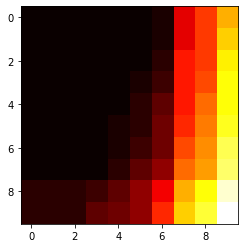

In [93]:
plot_heatmap(accu)

In [67]:
accu2 = get_accuracies(0.5, 1, 0.05, 0.5, 1, 0.05)

In [68]:
accu2[:5], accu2[-5:]

([(0.5, 0.5, 0.0001),
  (0.5, 0.55, 0.0002),
  (0.5, 0.6000000000000001, 0.0003),
  (0.5, 0.6500000000000001, 0.0007),
  (0.5, 0.7000000000000002, 0.00085)],
 [(0.9500000000000004, 0.7500000000000002, 0.00155),
  (0.9500000000000004, 0.8000000000000003, 0.0017),
  (0.9500000000000004, 0.8500000000000003, 0.00185),
  (0.9500000000000004, 0.9000000000000004, 0.00205),
  (0.9500000000000004, 0.9500000000000004, 0.0023)])

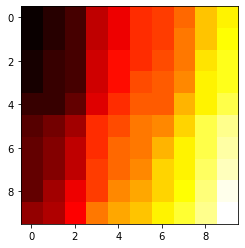

In [69]:
plot_heatmap(accu2)

In [75]:
accu3 = get_accuracies(1, 11, 0.5, 1, 11, 0.5)

In [76]:
# accu3[:5], accu3[-5:]
accu3

[(1.0, 1.0, 0.0177),
 (1.0, 1.5, 0.01915),
 (1.0, 2.0, 0.02115),
 (1.0, 2.5, 0.0223),
 (1.0, 3.0, 0.0236),
 (1.0, 3.5, 0.0243),
 (1.0, 4.0, 0.02475),
 (1.0, 4.5, 0.02535),
 (1.0, 5.0, 0.02595),
 (1.0, 5.5, 0.02635),
 (1.0, 6.0, 0.0265),
 (1.0, 6.5, 0.0267),
 (1.0, 7.0, 0.02685),
 (1.0, 7.5, 0.02685),
 (1.0, 8.0, 0.02705),
 (1.0, 8.5, 0.02725),
 (1.0, 9.0, 0.0274),
 (1.0, 9.5, 0.02745),
 (1.0, 10.0, 0.0276),
 (1.0, 10.5, 0.02775),
 (1.5, 1.0, 0.0462),
 (1.5, 1.5, 0.04765),
 (1.5, 2.0, 0.04995),
 (1.5, 2.5, 0.05085),
 (1.5, 3.0, 0.0519),
 (1.5, 3.5, 0.0525),
 (1.5, 4.0, 0.05315),
 (1.5, 4.5, 0.0537),
 (1.5, 5.0, 0.05425),
 (1.5, 5.5, 0.0545),
 (1.5, 6.0, 0.0547),
 (1.5, 6.5, 0.0548),
 (1.5, 7.0, 0.05495),
 (1.5, 7.5, 0.05505),
 (1.5, 8.0, 0.0552),
 (1.5, 8.5, 0.05535),
 (1.5, 9.0, 0.05555),
 (1.5, 9.5, 0.0557),
 (1.5, 10.0, 0.0559),
 (1.5, 10.5, 0.056),
 (2.0, 1.0, 0.08485),
 (2.0, 1.5, 0.08635),
 (2.0, 2.0, 0.0884),
 (2.0, 2.5, 0.0893),
 (2.0, 3.0, 0.0903),
 (2.0, 3.5, 0.09075),
 (2.0, 

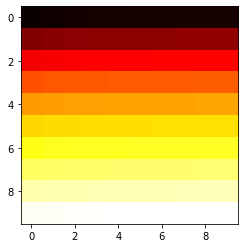

In [77]:
plot_heatmap(accu3)

In the weight ranges used by `accu3`, weight1 dominates.

In [78]:
accu4 = get_accuracies(11, 21, 0.5, 15, 16, 1)
accu4

[(11.0, 15, 0.4598),
 (11.5, 15, 0.4725),
 (12.0, 15, 0.48775),
 (12.5, 15, 0.5004),
 (13.0, 15, 0.513),
 (13.5, 15, 0.52475),
 (14.0, 15, 0.5362),
 (14.5, 15, 0.54705),
 (15.0, 15, 0.55455),
 (15.5, 15, 0.5641),
 (16.0, 15, 0.5726),
 (16.5, 15, 0.5813),
 (17.0, 15, 0.5894),
 (17.5, 15, 0.59615),
 (18.0, 15, 0.6026),
 (18.5, 15, 0.60945),
 (19.0, 15, 0.61465),
 (19.5, 15, 0.6197),
 (20.0, 15, 0.6243),
 (20.5, 15, 0.6285)]

In [79]:
accu5 = get_accuracies(21, 41, 1, 15, 16, 1)
accu5

[(21, 15, 0.633),
 (22, 15, 0.64095),
 (23, 15, 0.64825),
 (24, 15, 0.65405),
 (25, 15, 0.6597),
 (26, 15, 0.66435),
 (27, 15, 0.66885),
 (28, 15, 0.67275),
 (29, 15, 0.6766),
 (30, 15, 0.6794),
 (31, 15, 0.6824),
 (32, 15, 0.6851),
 (33, 15, 0.68785),
 (34, 15, 0.69075),
 (35, 15, 0.69325),
 (36, 15, 0.69515),
 (37, 15, 0.69745),
 (38, 15, 0.69985),
 (39, 15, 0.70185),
 (40, 15, 0.70395)]

In [80]:
accu6 = get_accuracies(41, 61, 0.5, 15, 16, 1)
accu6

[(41.0, 15, 0.7052),
 (41.5, 15, 0.7057),
 (42.0, 15, 0.70665),
 (42.5, 15, 0.7072),
 (43.0, 15, 0.70795),
 (43.5, 15, 0.7086),
 (44.0, 15, 0.70945),
 (44.5, 15, 0.7101),
 (45.0, 15, 0.71075),
 (45.5, 15, 0.7115),
 (46.0, 15, 0.71205),
 (46.5, 15, 0.7126),
 (47.0, 15, 0.7132),
 (47.5, 15, 0.7135),
 (48.0, 15, 0.71375),
 (48.5, 15, 0.7143),
 (49.0, 15, 0.71435),
 (49.5, 15, 0.71495),
 (50.0, 15, 0.71535),
 (50.5, 15, 0.7159),
 (51.0, 15, 0.7162),
 (51.5, 15, 0.7163),
 (52.0, 15, 0.71675),
 (52.5, 15, 0.71715),
 (53.0, 15, 0.71755),
 (53.5, 15, 0.71755),
 (54.0, 15, 0.71815),
 (54.5, 15, 0.71855),
 (55.0, 15, 0.7189),
 (55.5, 15, 0.7194),
 (56.0, 15, 0.71965),
 (56.5, 15, 0.71995),
 (57.0, 15, 0.7202),
 (57.5, 15, 0.72065),
 (58.0, 15, 0.7211),
 (58.5, 15, 0.72135),
 (59.0, 15, 0.72195),
 (59.5, 15, 0.7225),
 (60.0, 15, 0.7227),
 (60.5, 15, 0.7229)]

In [81]:
accu7 = get_accuracies(11, 101, 2, 15, 16, 1)
w1_to_accu = [(x, y) for x, _, y in accu7]
w1_to_accu

[(11, 0.4598),
 (13, 0.513),
 (15, 0.55455),
 (17, 0.5894),
 (19, 0.61465),
 (21, 0.633),
 (23, 0.64825),
 (25, 0.6597),
 (27, 0.66885),
 (29, 0.6766),
 (31, 0.6824),
 (33, 0.68785),
 (35, 0.69325),
 (37, 0.69745),
 (39, 0.70185),
 (41, 0.7052),
 (43, 0.70795),
 (45, 0.71075),
 (47, 0.7132),
 (49, 0.71435),
 (51, 0.7162),
 (53, 0.71755),
 (55, 0.7189),
 (57, 0.7202),
 (59, 0.72195),
 (61, 0.7235),
 (63, 0.72495),
 (65, 0.72625),
 (67, 0.72785),
 (69, 0.7287),
 (71, 0.7295),
 (73, 0.7305),
 (75, 0.7311),
 (77, 0.7321),
 (79, 0.7333),
 (81, 0.73385),
 (83, 0.7347),
 (85, 0.73545),
 (87, 0.73655),
 (89, 0.73725),
 (91, 0.73805),
 (93, 0.73875),
 (95, 0.73905),
 (97, 0.73965),
 (99, 0.74)]

In [82]:
accu8 = get_accuracies(101, 201, 10, 15, 16, 1)
w1_to_accu = [(x, y) for x, _, y in accu8]
w1_to_accu

[(101, 0.7405),
 (111, 0.74235),
 (121, 0.74335),
 (131, 0.74415),
 (141, 0.7448),
 (151, 0.74595),
 (161, 0.74615),
 (171, 0.7479),
 (181, 0.7488),
 (191, 0.74945)]

In [94]:
accu9 = get_accuracies(201, 2701, 100, 15, 16, 1)
w1_to_accu = [(x, y) for x, _, y in accu9]
w1_to_accu

[(201, 0.74975),
 (301, 0.7559),
 (401, 0.75715),
 (501, 0.75715),
 (601, 0.75715),
 (701, 0.75715),
 (801, 0.75715),
 (901, 0.75715),
 (1001, 0.75715),
 (1101, 0.75715),
 (1201, 0.75715),
 (1301, 0.75715),
 (1401, 0.75715),
 (1501, 0.75715),
 (1601, 0.75715),
 (1701, 0.75715),
 (1801, 0.75715),
 (1901, 0.75715),
 (2001, 0.75715),
 (2101, 0.75715),
 (2201, 0.75715),
 (2301, 0.75715),
 (2401, 0.75715),
 (2501, 0.75715),
 (2601, 0.75715)]

w1 doesn't seem to matter when it reaches 400.

In [95]:
accu9 = get_accuracies(400, 401, 1, 10, 200, 10)
w2_to_accu = [(x, y) for _, x, y in accu9]
w2_to_accu

[(10, 0.75695),
 (20, 0.7573),
 (30, 0.7576),
 (40, 0.75775),
 (50, 0.7581),
 (60, 0.7583),
 (70, 0.75835),
 (80, 0.7585),
 (90, 0.7585),
 (100, 0.7586),
 (110, 0.7587),
 (120, 0.75885),
 (130, 0.7589),
 (140, 0.7589),
 (150, 0.759),
 (160, 0.75905),
 (170, 0.75915),
 (180, 0.75935),
 (190, 0.75945)]

In [97]:
accu10 = get_accuracies(400, 401, 1, 200, 3000, 100)
w2_to_accu = [(x, y) for _, x, y in accu10]
w2_to_accu

[(200, 0.75945),
 (300, 0.76005),
 (400, 0.7605),
 (500, 0.76075),
 (600, 0.76085),
 (700, 0.76095),
 (800, 0.7611),
 (900, 0.7612),
 (1000, 0.7612),
 (1100, 0.7612),
 (1200, 0.7612),
 (1300, 0.7613),
 (1400, 0.76135),
 (1500, 0.76135),
 (1600, 0.7614),
 (1700, 0.76145),
 (1800, 0.76145),
 (1900, 0.7615),
 (2000, 0.7615),
 (2100, 0.7615),
 (2200, 0.7615),
 (2300, 0.7615),
 (2400, 0.7615),
 (2500, 0.7615),
 (2600, 0.7616),
 (2700, 0.7616),
 (2800, 0.7616),
 (2900, 0.7616)]

## Conclusion

The accuracy increases as both weights increase, and stays 0.76 when weight1 set to >=400 and weight2 set to >= 2600.